# Model that matches probabilities for labelled and unlabelled segments

In [38]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.append('..')

In [4]:
from src.preprocessing import (
    batch_parse_salary,
    _combine_name_cols,
    combine_time_with_employer,
    import_mortgage_table,
    import_campaign_table,
    _pays_capital_tax
)

In [5]:
# Import tables
campaign_df = import_campaign_table('../data/Campaign.csv', self_learning_setup=False)
mortgage_df = import_mortgage_table('../data/Mortgage.csv')

Getting exhange rates...


In [6]:
# Feature names
feature_names = [
    'age',
    'marital_status',
    'occupation_level',
    'education_num',
    'familiarity_FB',
    'view_FB',
    'interested_insurance',
    'salary_band',
    'hours_per_week',
    'workclass',
    'total_months_with_employer',
    'pays_captial_tax'
]

In [7]:
# Concat the tables
combined_df = pd.concat([campaign_df, mortgage_df], axis=1)
combined_df = combined_df.dropna(subset=feature_names)
combined_df = combined_df[feature_names + ['created_account']]
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29959 entries, 0 to 32059
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         29959 non-null  float64 
 1   marital_status              29959 non-null  category
 2   occupation_level            29959 non-null  float64 
 3   education_num               29959 non-null  float64 
 4   familiarity_FB              29959 non-null  float64 
 5   view_FB                     29959 non-null  float64 
 6   interested_insurance        29959 non-null  float64 
 7   salary_band                 29959 non-null  float64 
 8   hours_per_week              29959 non-null  int64   
 9   workclass                   29959 non-null  category
 10  total_months_with_employer  29959 non-null  int64   
 11  pays_captial_tax            29959 non-null  int64   
 12  created_account             2809 non-null   string  
dtypes: category(2), 

In [8]:
combined_df.created_account.value_counts()

No     2575
Yes     234
Name: created_account, dtype: Int64

In [9]:
# Split into labelled and unlabelled subsets
labelled_df = combined_df[~combined_df.created_account.isna()]
unlabelled_df = combined_df[combined_df.created_account.isna()]

In [10]:
labelled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2809 entries, 0 to 3026
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         2809 non-null   float64 
 1   marital_status              2809 non-null   category
 2   occupation_level            2809 non-null   float64 
 3   education_num               2809 non-null   float64 
 4   familiarity_FB              2809 non-null   float64 
 5   view_FB                     2809 non-null   float64 
 6   interested_insurance        2809 non-null   float64 
 7   salary_band                 2809 non-null   float64 
 8   hours_per_week              2809 non-null   int64   
 9   workclass                   2809 non-null   category
 10  total_months_with_employer  2809 non-null   int64   
 11  pays_captial_tax            2809 non-null   int64   
 12  created_account             2809 non-null   string  
dtypes: category(2), fl

In [11]:
unlabelled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27150 entries, 3027 to 32059
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         27150 non-null  float64 
 1   marital_status              27150 non-null  category
 2   occupation_level            27150 non-null  float64 
 3   education_num               27150 non-null  float64 
 4   familiarity_FB              27150 non-null  float64 
 5   view_FB                     27150 non-null  float64 
 6   interested_insurance        27150 non-null  float64 
 7   salary_band                 27150 non-null  float64 
 8   hours_per_week              27150 non-null  int64   
 9   workclass                   27150 non-null  category
 10  total_months_with_employer  27150 non-null  int64   
 11  pays_captial_tax            27150 non-null  int64   
 12  created_account             0 non-null      string  
dtypes: category(2

In [12]:
# Binerize the labels
lb = LabelBinarizer().fit(labelled_df["created_account"])
created_account_binary = lb.transform(labelled_df["created_account"])
labelled_df["created_account"] = created_account_binary

/var/folders/_1/7f6t8txx15d5s33kvnp_g7n00000gn/T/ipykernel_78371/1603307160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_df["created_account"] = created_account_binary


In [53]:
# Split labelled into X and y
X_lab, y_lab = labelled_df.iloc[:,:-1], labelled_df.iloc[:,-1]

In [14]:
# Baseline Random Forest (use only labelled data)
rdf = RandomForestClassifier()

In [15]:
# Oversample minority class
ros = RandomOverSampler()

In [16]:
# Encode by the columns
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(handle_unknown='ignore'), ["marital_status", "workclass"])],
    remainder='passthrough', verbose_feature_names_out=False
)

In [17]:
# Make pipeline
pipeline = Pipeline(
    steps=[
        ("random_over_sample", ros),
        ("encoder", ct),
        ("random_forest", rdf),
    ]
)

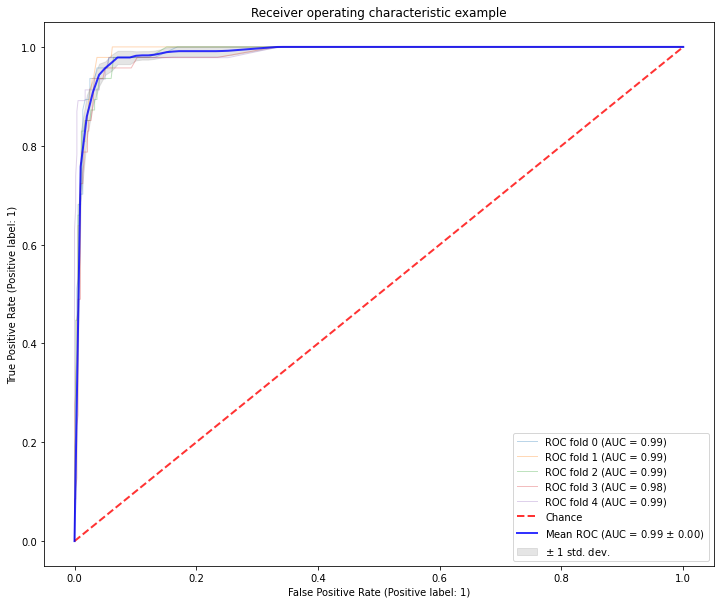

In [18]:
# Cross-validated ROC curve
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12,10))
for i , (train, test) in enumerate(cv.split(X_lab, y_lab)):
    pipeline.fit(X_lab.iloc[train], y_lab.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        pipeline,
        X_lab.iloc[test],
        y_lab.iloc[test],
        name=f"ROC fold {i}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.3)

In [77]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_probas = pipeline.predict_proba(X_test)

In [78]:
X_unlab = unlabelled_df.iloc[:, :-1]
proba_unlab = pipeline.predict_proba(X_unlab)[:,1]
pred_unlab = pipeline.predict(X_unlab)

In [79]:
proba_unlab

array([0.93, 0.  , 0.03, ..., 0.02, 0.  , 0.03])

In [80]:
# Get percent accepted home insurance on labelled subset
y_lab.value_counts()[1] / y_lab.value_counts()[0]

0.09087378640776698

In [81]:
def match_threshold(probas: np.ndarray, percent_accept: float) -> float:
    thresh = 0.0
    while thresh != 1.0:
        accept = (probas > thresh).sum() / len(probas)
        if accept < percent_accept:
            return thresh
        thresh += 0.01

In [82]:
match_threshold(proba_unlab, 0.09)

0.36000000000000015

In [83]:
def predict_threshold(probas: np.ndarray, threshold: float) -> np.ndarray:
    return (probas > threshold).astype('float')

In [84]:
pred_unlab_thresh = predict_threshold(proba_unlab, 0.37)

In [85]:
# Default threshold 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       774
           1       0.87      0.86      0.86        69

    accuracy                           0.98       843
   macro avg       0.93      0.92      0.92       843
weighted avg       0.98      0.98      0.98       843



In [89]:
# Custome threshold
y_pred_new = predict_threshold(y_probas, 0.37)[:,1]
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       774
           1       0.80      0.94      0.87        69

    accuracy                           0.98       843
   macro avg       0.90      0.96      0.93       843
weighted avg       0.98      0.98      0.98       843

